In [47]:
import tqdm
import random
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from sklearn.tree import DecisionTreeClassifier

In [2]:
def calc_accuracy(model, X, y_true):
    y_pred = model.predict(X)
    accuracy = (y_true == y_pred).mean()
    return accuracy

In [3]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                       np.arange(y_min, y_max, 0.01))

def plot_model(X, y, clf, proba=False, title=''):
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(16, 8))    
    plt.title(title)
    plt.pcolormesh(xx, yy, predicted, alpha=0.7, cmap='spring')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=100, edgecolors='b', linewidths=1, cmap='spring')
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.show()

In [68]:
class BaggingClassifier(object):
    
    def __init__(self, base_model_class, n_base_models, **base_model_params):
        self.OOB_indices = []
        self.n_base_models = n_base_models
        self.base_models = [self._create_model_(base_model_class, **base_model_params) 
                            for _ in range(self.n_base_models)]
    
    def _create_model_(self, base_model_class, **base_model_params):
        return base_model_class(**base_model_params)
    
    def _create_bagging_subsample_(self, X, y):
        X_bagging, y_bagging = None, None
        index = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        self.OOB_indices.append(list(set(range(X.shape[0])) - set(index)))
        X_bagging, y_bagging = X[index], y[index]
        return X_bagging, y_bagging
        
    def train(self, X, y):
        for base_model in self.base_models:
            X_bagging, y_bagging = self._create_bagging_subsample_(X, y)
            base_model.fit(X_bagging, y_bagging)
    
    def predict(self, X):
        base_models_predictions = np.asarray([base_model.predict(X) for base_model in self.base_models], dtype=np.int).transpose(1, 0)  
        result = []
        for base_models_p in base_models_predictions:
            uniques, counts = np.unique(base_models_p, return_counts=True)
            result.append(uniques[np.argmax(counts)])
        return np.asarray(result)
    
    def predict_proba(self, X):
        base_models_predictions = np.asarray([base_model.predict_proba(X) 
                                              for base_model in self.base_models], dtype=np.float).transpose(1, 0, 2)  
        return base_models_predictions.mean(axis=1)
    
    def get_OOB(self, X, y):
        res = 0
        for i in range(self.n_base_models):
            ind = self.OOB_indices[i]
            y_pred = self.base_models[i].predict(X[ind])
            res += np.mean(y_pred == y[ind])
        return res/self.n_base_models

In [43]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                       np.arange(y_min, y_max, 0.01))

def plot_model(X, y, clf, proba=False, title=''):
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(16, 8))    
    plt.title(title)
    plt.pcolormesh(xx, yy, predicted, alpha=0.7, cmap = "spring")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=100, edgecolors='b', linewidths=1, cmap = "spring")
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.show()

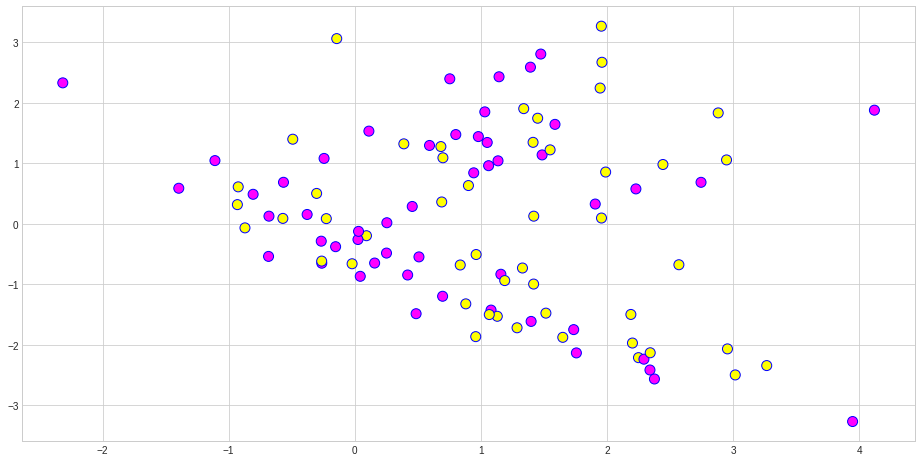

In [63]:
from sklearn.datasets import make_classification

X_toy, y_toy = make_classification(n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, flip_y=1)
plt.figure(figsize=(16, 8))
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, edgecolors='b', linewidths=1, s=100, cmap='spring')
plt.show()

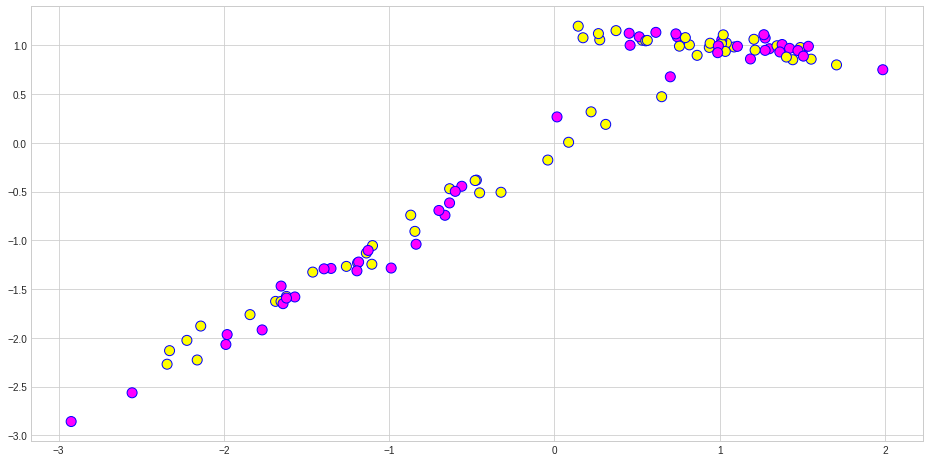

In [64]:
X_toy_test, y_toy_test = make_classification(n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, flip_y=1)
plt.figure(figsize=(16, 8))
plt.scatter(X_toy_test[:, 0], X_toy_test[:, 1], c=y_toy_test, edgecolors='b', linewidths=1, s=100, cmap='spring')
plt.show()

n_base_models: 1, accuracy: 0.780, OOB_score: 0.405


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


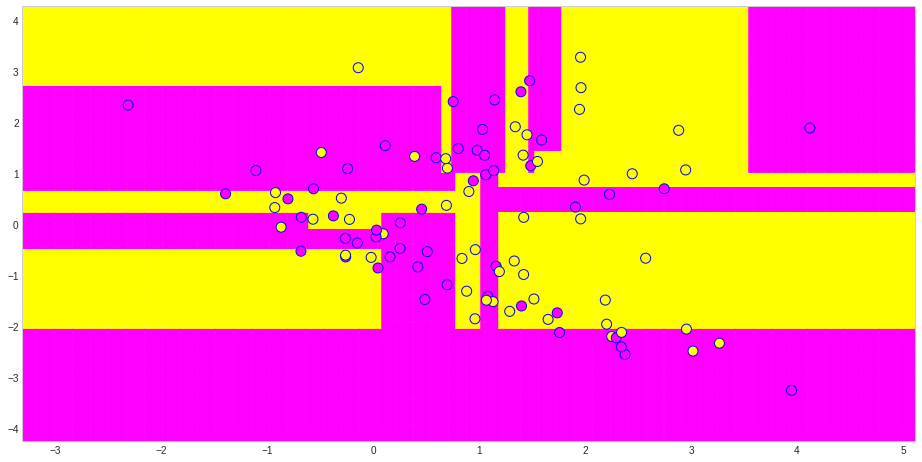

n_base_models: 2, accuracy: 0.880, OOB_score: 0.497


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


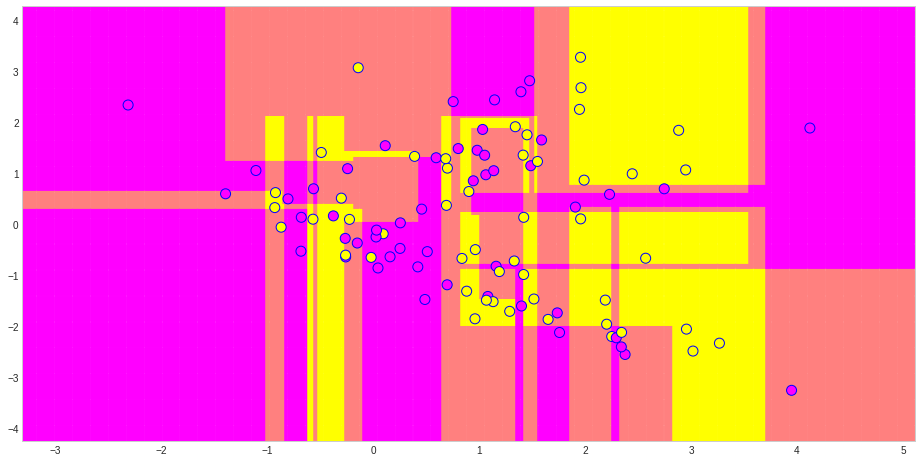

n_base_models: 5, accuracy: 0.980, OOB_score: 0.485


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


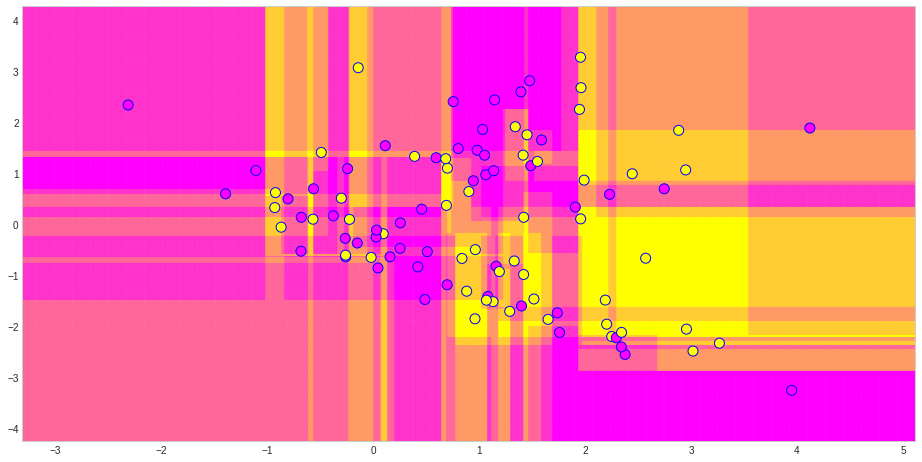

n_base_models: 10, accuracy: 0.970, OOB_score: 0.518


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


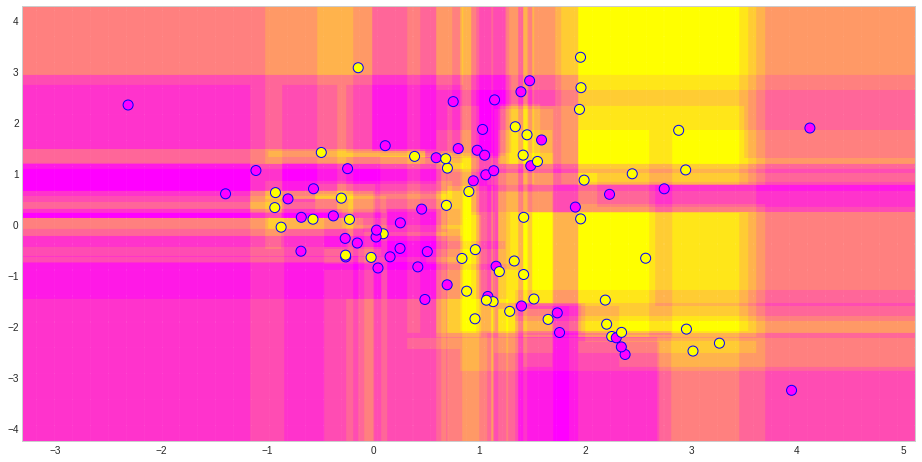

n_base_models: 15, accuracy: 0.990, OOB_score: 0.467


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


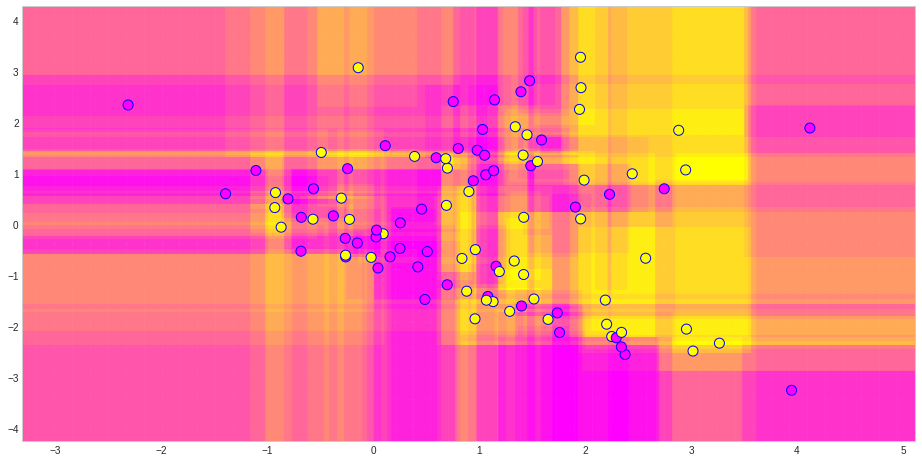

In [69]:
for n_base_models in (1, 2, 5, 10, 15):
    bagger = BaggingClassifier(base_model_class=DecisionTreeClassifier, n_base_models=n_base_models)
    bagger.train(X_toy, y_toy)
    
    y_pred = bagger.predict(X_toy)
    accuracy = (y_toy == y_pred).mean()
    print('n_base_models: {}, accuracy: {:.3f}, OOB_score: {:.3f}'.format(n_base_models, accuracy,
                                                                      bagger.get_OOB(X_toy, y_toy)))
    
    plot_model(X_toy, y_toy, bagger, proba=True)

n_base_models: 1, accuracy: 0.410


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


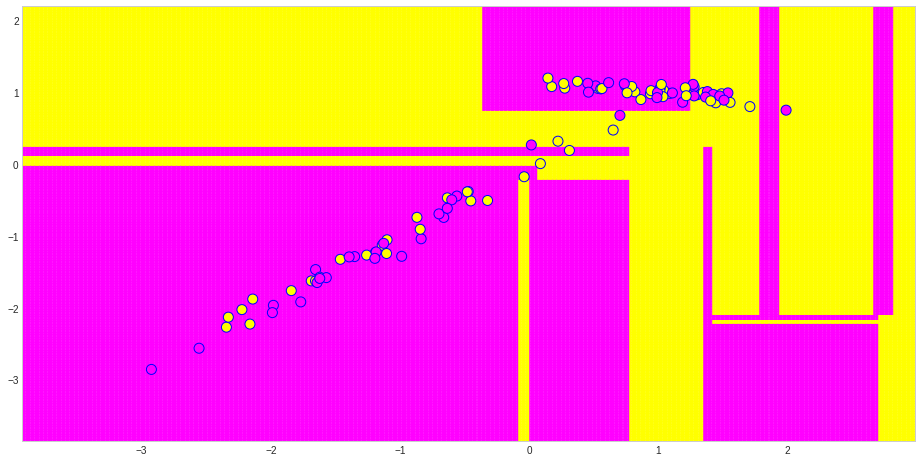

n_base_models: 2, accuracy: 0.450


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


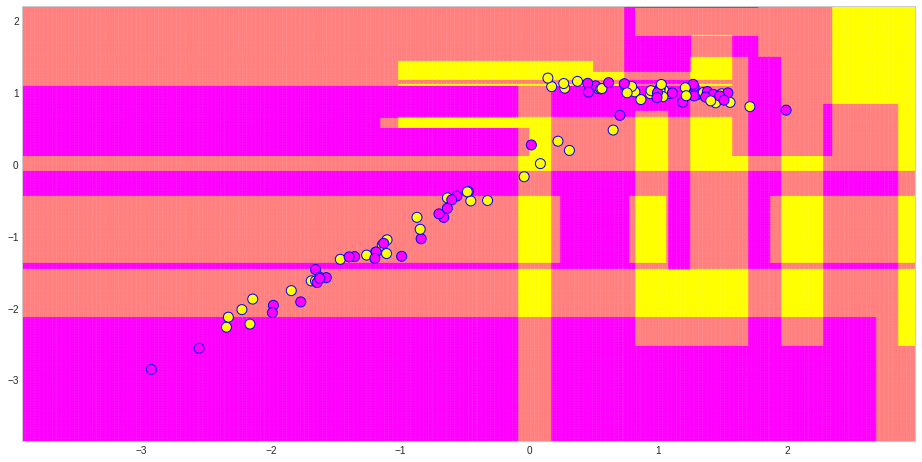

n_base_models: 5, accuracy: 0.420


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


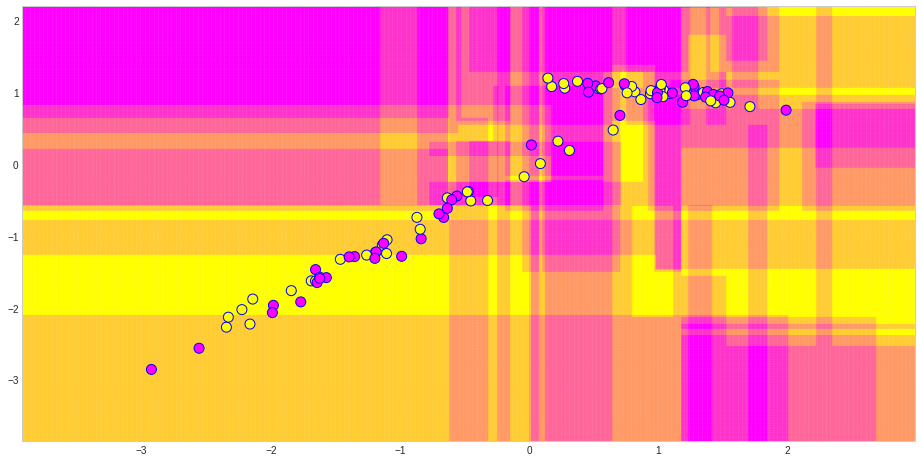

n_base_models: 10, accuracy: 0.470


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


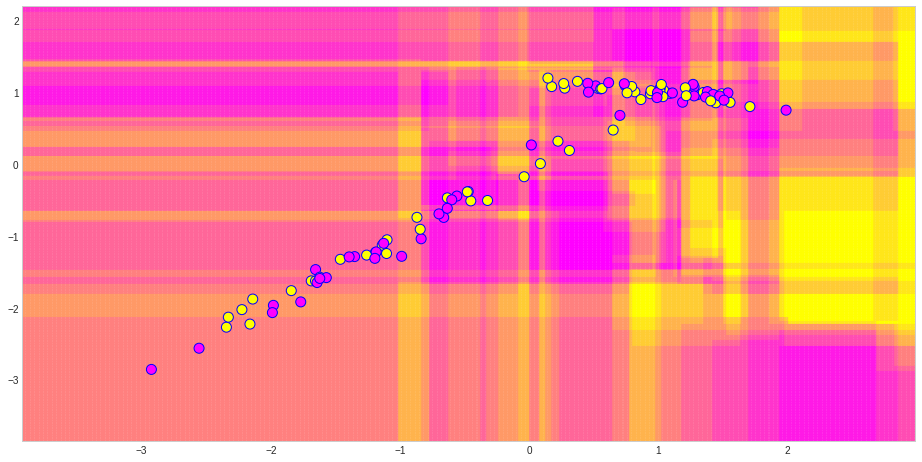

n_base_models: 15, accuracy: 0.450


/home/artem/miniconda3/envs/newenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


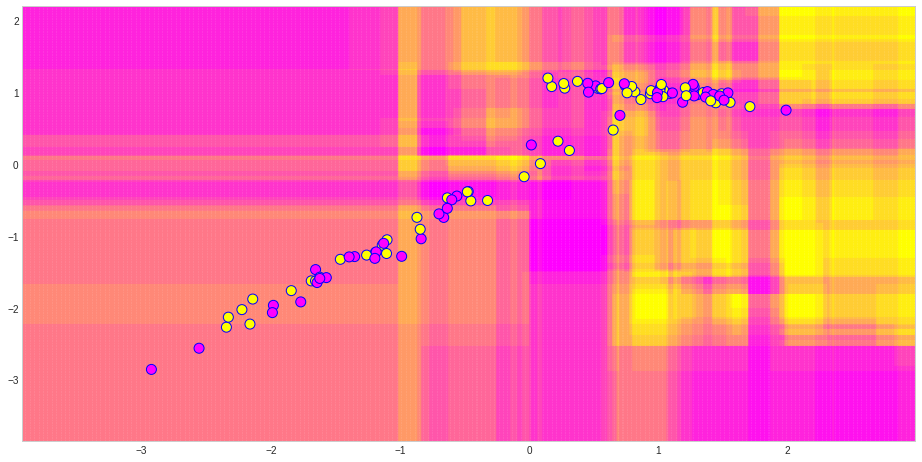

In [72]:
for n_base_models in (1, 2, 5, 10, 15):
    bagger = BaggingClassifier(base_model_class=DecisionTreeClassifier, n_base_models=n_base_models)
    bagger.train(X_toy, y_toy)
    
    y_pred = bagger.predict(X_toy_test)
    accuracy = (y_toy_test == y_pred).mean()
    print('n_base_models: {}, accuracy: {:.3f}'.format(n_base_models, accuracy))

    plot_model(X_toy_test, y_toy_test, bagger, proba=True)